# Soccer Analytics : Transition from defense to attack


## Objective
Understand transition action success per team in one match


In [1]:
%pip install sqlalchemy matplotsoccer mplsoccer psycopg2 dotenv pandas -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 1: Load Data


In [2]:
import psycopg2
import dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch
from matplotlib.cm import get_cmap
import pandas as pd
import mplsoccer
from matplotlib import colors as matplotlib_colors
import numpy as np  



In [3]:
def get_database_connection():
    """
    Establish and return a connection to the PostgreSQL database.

    Returns:
        psycopg2.extensions.connection: A connection object to the database.
    """
    dotenv.load_dotenv()

    PG_PASSWORD = os.getenv("PG_PASSWORD")
    PG_USER = os.getenv("PG_USER")
    PG_HOST = os.getenv("PG_HOST")
    PG_PORT = os.getenv("PG_PORT")
    PG_DATABASE = os.getenv("PG_DB")

    try:
        # Establish and return the database connection
        conn = psycopg2.connect(
            host=PG_HOST,
            database=PG_DATABASE,
            user=PG_USER,
            password=PG_PASSWORD,
            port=PG_PORT,
            sslmode="require",
        )
        print("Successful database login!")
        return conn
    except psycopg2.Error as e:
        print(f"Database connexion error : {e}")
        return None

# calling function
conn = get_database_connection()


Successful database login!


## Step 2: Query the Database

- This query is a complex query that has been improved

In [4]:
def complexDfQuery(game_id, our_team, opponent_team, conn):
    complexQuery = f"""
    WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM
        public.spadl_actions a
    WHERE
        a.game_id = '{game_id}'
    ),

    possession_markers AS (
        SELECT
            *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
        FROM
            action_changes
    ),

    possession_groups AS (
        SELECT
            *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
        FROM
            possession_markers
    ),

    possession_changes AS (
    SELECT
        *,
        CASE 
            WHEN prev_team_id = '{our_team}' AND team_id = '{opponent_team}' THEN 'A to B'
            WHEN prev_team_id = '{opponent_team}' AND team_id = '{our_team}' THEN 'B to A'
            ELSE 'No Change'
        END AS possession_change
    FROM
        possession_groups
    ),

    count_rows_in_possession_group AS (
        SELECT
            *,
            COUNT(*) OVER (PARTITION BY possession_group ORDER BY period_id, seconds, id) AS rows_in_possession_group
        FROM
            possession_changes
    ),

    initial_value_per_group AS (
    SELECT
        possession_group,
        MIN(seconds) AS initial_seconds
    FROM
        count_rows_in_possession_group
    GROUP BY
        possession_group
    ),

    possession_stats AS (
    SELECT
        possession_group,
        team_id,
        COUNT(*) AS action_count,
        MAX(id) AS last_action_id
    FROM
        count_rows_in_possession_group
    GROUP BY
        possession_group, team_id
    ),

    final_query AS (
    SELECT
        c.*, 
        (c.seconds - i.initial_seconds) AS seconds_difference,
        ABS(c.start_x - c.end_x) AS action_distance
    FROM
        count_rows_in_possession_group c
    JOIN 
        initial_value_per_group i
    ON 
        c.possession_group = i.possession_group
    ),

    start_with_ball_table AS (
    SELECT *,
        CASE 
            WHEN FIRST_VALUE(prev_team_id) OVER (ORDER BY id) IS NULL AND FIRST_VALUE(end_x) OVER (ORDER BY id) < 52.5
            THEN 'LEFT_SIDE' 
            ELSE 'RIGHT_SIDE' 
        END AS start_with_ball
    FROM final_query
    ),

    start_with_period AS (
    SELECT *,
        CASE 
            WHEN start_with_ball = 'LEFT_SIDE' and period_id = 2
            THEN 'RIGHT_SIDE' 
            WHEN start_with_ball = 'RIGHT_SIDE' and period_id = 2
            THEN 'LEFT_SIDE' 
            WHEN start_with_ball = 'LEFT_SIDE' and period_id = 1
            THEN 'LEFT_SIDE' 
            WHEN start_with_ball = 'RIGHT_SIDE' and period_id = 1
            THEN 'RIGHT_SIDE' 
        END AS update_start_with_ball
    FROM start_with_ball_table
    ),

    isgoal AS (
    SELECT *,
        CASE 
            when start_x < end_x and update_start_with_ball = 'RIGHT_SIDE' then 'FORWARD'
            when start_x > end_x and update_start_with_ball = 'RIGHT_SIDE' then 'BACKWARD'
            when start_x < end_x and update_start_with_ball = 'LEFT_SIDE' then 'BACKWARD'
            when start_x > end_x and update_start_with_ball = 'LEFT_SIDE' then 'FORWARD'
            else NULL
        END AS ballMoveDirection,
        CASE
            when action_type = '10' and result = '1' then '1'
            else '0'
        END AS isGoal
    FROM start_with_period
    WHERE team_id = '{our_team}'
        AND possession_group IN (
            SELECT possession_group FROM possession_stats WHERE action_count >= 3
        )
    ),

    goal_possession_groups AS (
        SELECT DISTINCT possession_group
        FROM isgoal
        WHERE isGoal = '1'
    )
    SELECT 
    g.*,
    CASE 
        WHEN g.possession_group IN (SELECT possession_group FROM goal_possession_groups) THEN '1'
        ELSE g.isGoal
    END AS sequenceIsGoal
FROM 
    isgoal g
    
WHERE seconds_difference <= 10;
"""
    return pd.read_sql_query(complexQuery, conn)

complexDf = complexDfQuery("5uts2s7fl98clqz8uymaazehg", "8y3iucyxguipljcmf87a11bk9", "4dtif7outbuivua8umbwegoo5", conn)
complexDf = complexDf.drop(columns=["start_with_ball"])
complexDf = complexDf.rename(columns={"update_start_with_ball": "start_with_ball"})
complexDf.head(1000)

,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,...,is_new_possession,possession_group,possession_change,rows_in_possession_group,seconds_difference,action_distance,start_with_ball,ballmovedirection,isgoal,sequenceisgoal
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,60gs7lod7de72ypcs6qfup8q2,8y3iucyxguipljcmf87a11bk9,52.500,34.000,43.365,36.312,...,1,1,No Change,1,0.0,9.135,LEFT_SIDE,FORWARD,0,0
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,43.365,36.312,48.720,34.680,...,0,1,No Change,2,0.5,5.355,LEFT_SIDE,BACKWARD,0,0
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,48.720,34.680,45.150,50.184,...,0,1,No Change,3,1.0,3.570,LEFT_SIDE,FORWARD,0,0
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,8fs5klbsyx06c5ds9s1i3xu96,8y3iucyxguipljcmf87a11bk9,46.200,48.008,39.270,63.376,...,0,1,No Change,4,4.0,6.930,LEFT_SIDE,FORWARD,0,0
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,39.270,63.376,42.945,63.920,...,0,1,No Change,5,5.0,3.675,LEFT_SIDE,BACKWARD,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,27189,5uts2s7fl98clqz8uymaazehg,2,3034.0,7s4ws0u4erq1jfobqpsj0aoes,8y3iucyxguipljcmf87a11bk9,5.355,26.452,22.785,17.204,...,0,419,No Change,3,3.0,17.430,RIGHT_SIDE,FORWARD,0,0
671,27190,5uts2s7fl98clqz8uymaazehg,2,3035.0,bdslzeqnm2a3o9yr1tsxuoydw,8y3iucyxguipljcmf87a11bk9,22.785,17.204,22.785,17.204,...,0,419,No Change,4,4.0,0.000,RIGHT_SIDE,None,0,0
672,27194,5uts2s7fl98clqz8uymaazehg,2,3075.0,be0ws51ws5cm9wzmcp3ozmklx,8y3iucyxguipljcmf87a11bk9,3.990,30.532,52.605,23.120,...,1,421,B to A,1,0.0,48.615,RIGHT_SIDE,FORWARD,0,0
673,27195,5uts2s7fl98clqz8uymaazehg,2,3079.0,bdslzeqnm2a3o9yr1tsxuoydw,8y3iucyxguipljcmf87a11bk9,51.765,23.392,62.580,22.440,...,0,421,No Change,2,4.0,10.815,RIGHT_SIDE,FORWARD,0,0


- Extraction of actions success 10s after the ball possession changes

In [28]:

# def extract_action_data(game_id, conn):
#     query = """
#     WITH action_changes AS (
#         SELECT
#             a.*,
#             LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id
#         FROM
#             public.spadl_actions a
#         WHERE
#             a.game_id = %(game_id)s
#     ),

#     possession_changes AS (
#         SELECT
#             *,
#             CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
#         FROM
#             action_changes
#     ),

#     possession_groups AS (
#         SELECT
#             *,
#             SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
#         FROM
#             possession_changes
#     ),

#     possession_start_times AS (
#         SELECT
#             possession_group,
#             MIN(seconds) AS possession_start_time
#         FROM
#             possession_groups
#         GROUP BY
#             possession_group
#     ),

#     teams_info AS (
#         SELECT DISTINCT
#             a.game_id,
#             a.team_id,
#             t.team_name
#         FROM
#             public.spadl_actions a
#         JOIN public.teams t ON a.team_id = t.team_id
#         WHERE a.game_id = %(game_id)s
#     ),

#     match_info AS (
#         SELECT
#             m.match_id AS game_id,
#             m.match_date,
#             m.home_team_id,
#             m.away_team_id
#         FROM
#             public.matches m
#         WHERE
#             m.match_id = %(game_id)s
#     )

#     SELECT
#         mi.match_date,
#         a.id,
#         a.seconds AS second,
#         a.period_id AS period,
#         t.team_name,
#         p.player_name,
#         a.action_type,
#         a.result,
#         a.start_x,
#         a.start_y,
#         a.end_x,
#         a.end_y,
#         CASE 
#             WHEN (a.period_id = 1 AND ((a.team_id = mi.home_team_id AND a.start_x <= 30) OR (a.team_id = mi.away_team_id AND a.start_x >= 60)))
#                  OR (a.period_id = 2 AND ((a.team_id = mi.home_team_id AND a.start_x >= 60) OR (a.team_id = mi.away_team_id AND a.start_x <= 30)))
#             THEN 'Defense'
#             WHEN a.start_x > 30 AND a.start_x < 60 
#             THEN 'Midfield'
#             ELSE 'Attack'
#         END AS field_zone,
#         CASE
#             WHEN a.action_type = '10' AND a.result = '1' THEN 1
#             ELSE 0
#         END AS is_goal
#     FROM
#         possession_groups a
#     JOIN possession_start_times pst ON a.possession_group = pst.possession_group
#     LEFT JOIN public.teams t ON a.team_id = t.team_id
#     LEFT JOIN public.players p ON a.player_id = p.player_id
#     JOIN teams_info t_info ON a.team_id = t_info.team_id
#     JOIN match_info mi ON a.game_id = mi.game_id
#     WHERE (a.seconds - pst.possession_start_time) <= 10
#     AND (
#         (a.period_id = 1 AND ((a.team_id = mi.home_team_id AND a.start_x <= 30) OR (a.team_id = mi.away_team_id AND a.start_x >= 60))) 
#         OR (a.period_id = 2 AND ((a.team_id = mi.home_team_id AND a.start_x >= 60) OR (a.team_id = mi.away_team_id AND a.start_x <= 30)))
#     )
#     """

#     return pd.read_sql_query(query, conn, params={"game_id": game_id})


#Function to extract action data in all the field

def extract_action_data(game_id, conn):
    query = """
    WITH action_changes AS (
        SELECT
            a.*,
            LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id
        FROM
            public.spadl_actions a
        WHERE
            a.game_id = %(game_id)s
    ),

    possession_changes AS (
        SELECT
            *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
        FROM
            action_changes
    ),

    possession_groups AS (
        SELECT
            *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
        FROM
            possession_changes
    ),

    possession_start_times AS (
        SELECT
            possession_group,
            MIN(seconds) AS possession_start_time
        FROM
            possession_groups
        GROUP BY
            possession_group
    ),

    teams_info AS (
        SELECT DISTINCT
            a.game_id,
            a.team_id,
            t.team_name
        FROM
            public.spadl_actions a
        JOIN public.teams t ON a.team_id = t.team_id
        WHERE a.game_id = %(game_id)s
    ),

    match_info AS (
        SELECT
            m.match_id AS game_id,
            m.match_date,
            m.home_team_id,
            m.away_team_id
        FROM
            public.matches m
        WHERE
            m.match_id = %(game_id)s
    )

    SELECT
        mi.match_date,
        a.id,
        a.seconds AS second,
        a.period_id AS period,
        t.team_name,
        p.player_name,
        a.action_type,
        a.result,
        a.start_x,
        a.start_y,
        a.end_x,
        a.end_y,
        CASE 
            WHEN (a.period_id = 1 AND ((a.team_id = mi.home_team_id AND a.start_x <= 30) OR (a.team_id = mi.away_team_id AND a.start_x >= 60)))
                 OR (a.period_id = 2 AND ((a.team_id = mi.home_team_id AND a.start_x >= 60) OR (a.team_id = mi.away_team_id AND a.start_x <= 30)))
            THEN 'Defense'
            WHEN a.start_x > 30 AND a.start_x < 60 
            THEN 'Midfield'
            ELSE 'Attack'
        END AS field_zone,
        CASE
            WHEN a.action_type = '10' AND a.result = '1' THEN 1
            ELSE 0
        END AS is_goal
    FROM
        possession_groups a
    JOIN possession_start_times pst ON a.possession_group = pst.possession_group
    LEFT JOIN public.teams t ON a.team_id = t.team_id
    LEFT JOIN public.players p ON a.player_id = p.player_id
    JOIN teams_info t_info ON a.team_id = t_info.team_id
    JOIN match_info mi ON a.game_id = mi.game_id
    WHERE (a.seconds - pst.possession_start_time) <= 10
    """

    return pd.read_sql_query(query, conn, params={"game_id": game_id})


def get_final_score(game_id, conn):
    score_query = """
    SELECT 
        m.home_score,
        m.away_score
    FROM 
        public.matches m
    WHERE 
        m.match_id = %(game_id)s
    """
    
    # Execute the query and retrieve the score
    score = pd.read_sql_query(score_query, conn, params={"game_id": game_id}).iloc[0]
    
    return score['home_score'], score['away_score']


# Test the function
game_id = "75xyj0hlct5wqv6uamxf8c1ec"

home_score, away_score = get_final_score(game_id, conn)
df_transition_action = extract_action_data(game_id, conn)
df_transition_action.head(100)


,match_date,id,second,period,team_name,player_name,action_type,result,start_x,start_y,end_x,end_y,field_zone,is_goal
0,2024-12-15,231767,0.0,1,Westerlo,M. Frigan,0,1,52.395,33.864,76.545,37.536,Midfield,0
1,2024-12-15,231768,1.0,1,Westerlo,D. Haspolat,21,1,76.545,37.536,72.345,39.032,Defense,0
2,2024-12-15,231769,2.0,1,Westerlo,D. Haspolat,0,1,72.345,39.032,30.240,8.636,Defense,0
3,2024-12-15,231770,4.5,1,Westerlo,T. Rommens,21,1,30.240,8.636,25.305,4.760,Midfield,0
4,2024-12-15,231771,7.0,1,Westerlo,T. Rommens,0,1,25.305,4.760,12.180,11.220,Attack,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2024-12-15,231904,527.0,1,Westerlo,M. Frigan,0,1,21.840,9.860,20.895,3.808,Attack,0
96,2024-12-15,231905,531.0,1,Westerlo,T. Rommens,0,1,19.845,6.392,25.095,2.584,Attack,0
97,2024-12-15,231906,533.0,1,Westerlo,A. Sayyadmanesh,0,1,23.625,3.196,22.680,23.052,Attack,0
98,2024-12-15,231907,534.0,1,Westerlo,M. Frigan,0,1,21.210,22.780,9.975,5.984,Attack,0


## Step 3: Visualizations to analyze the data

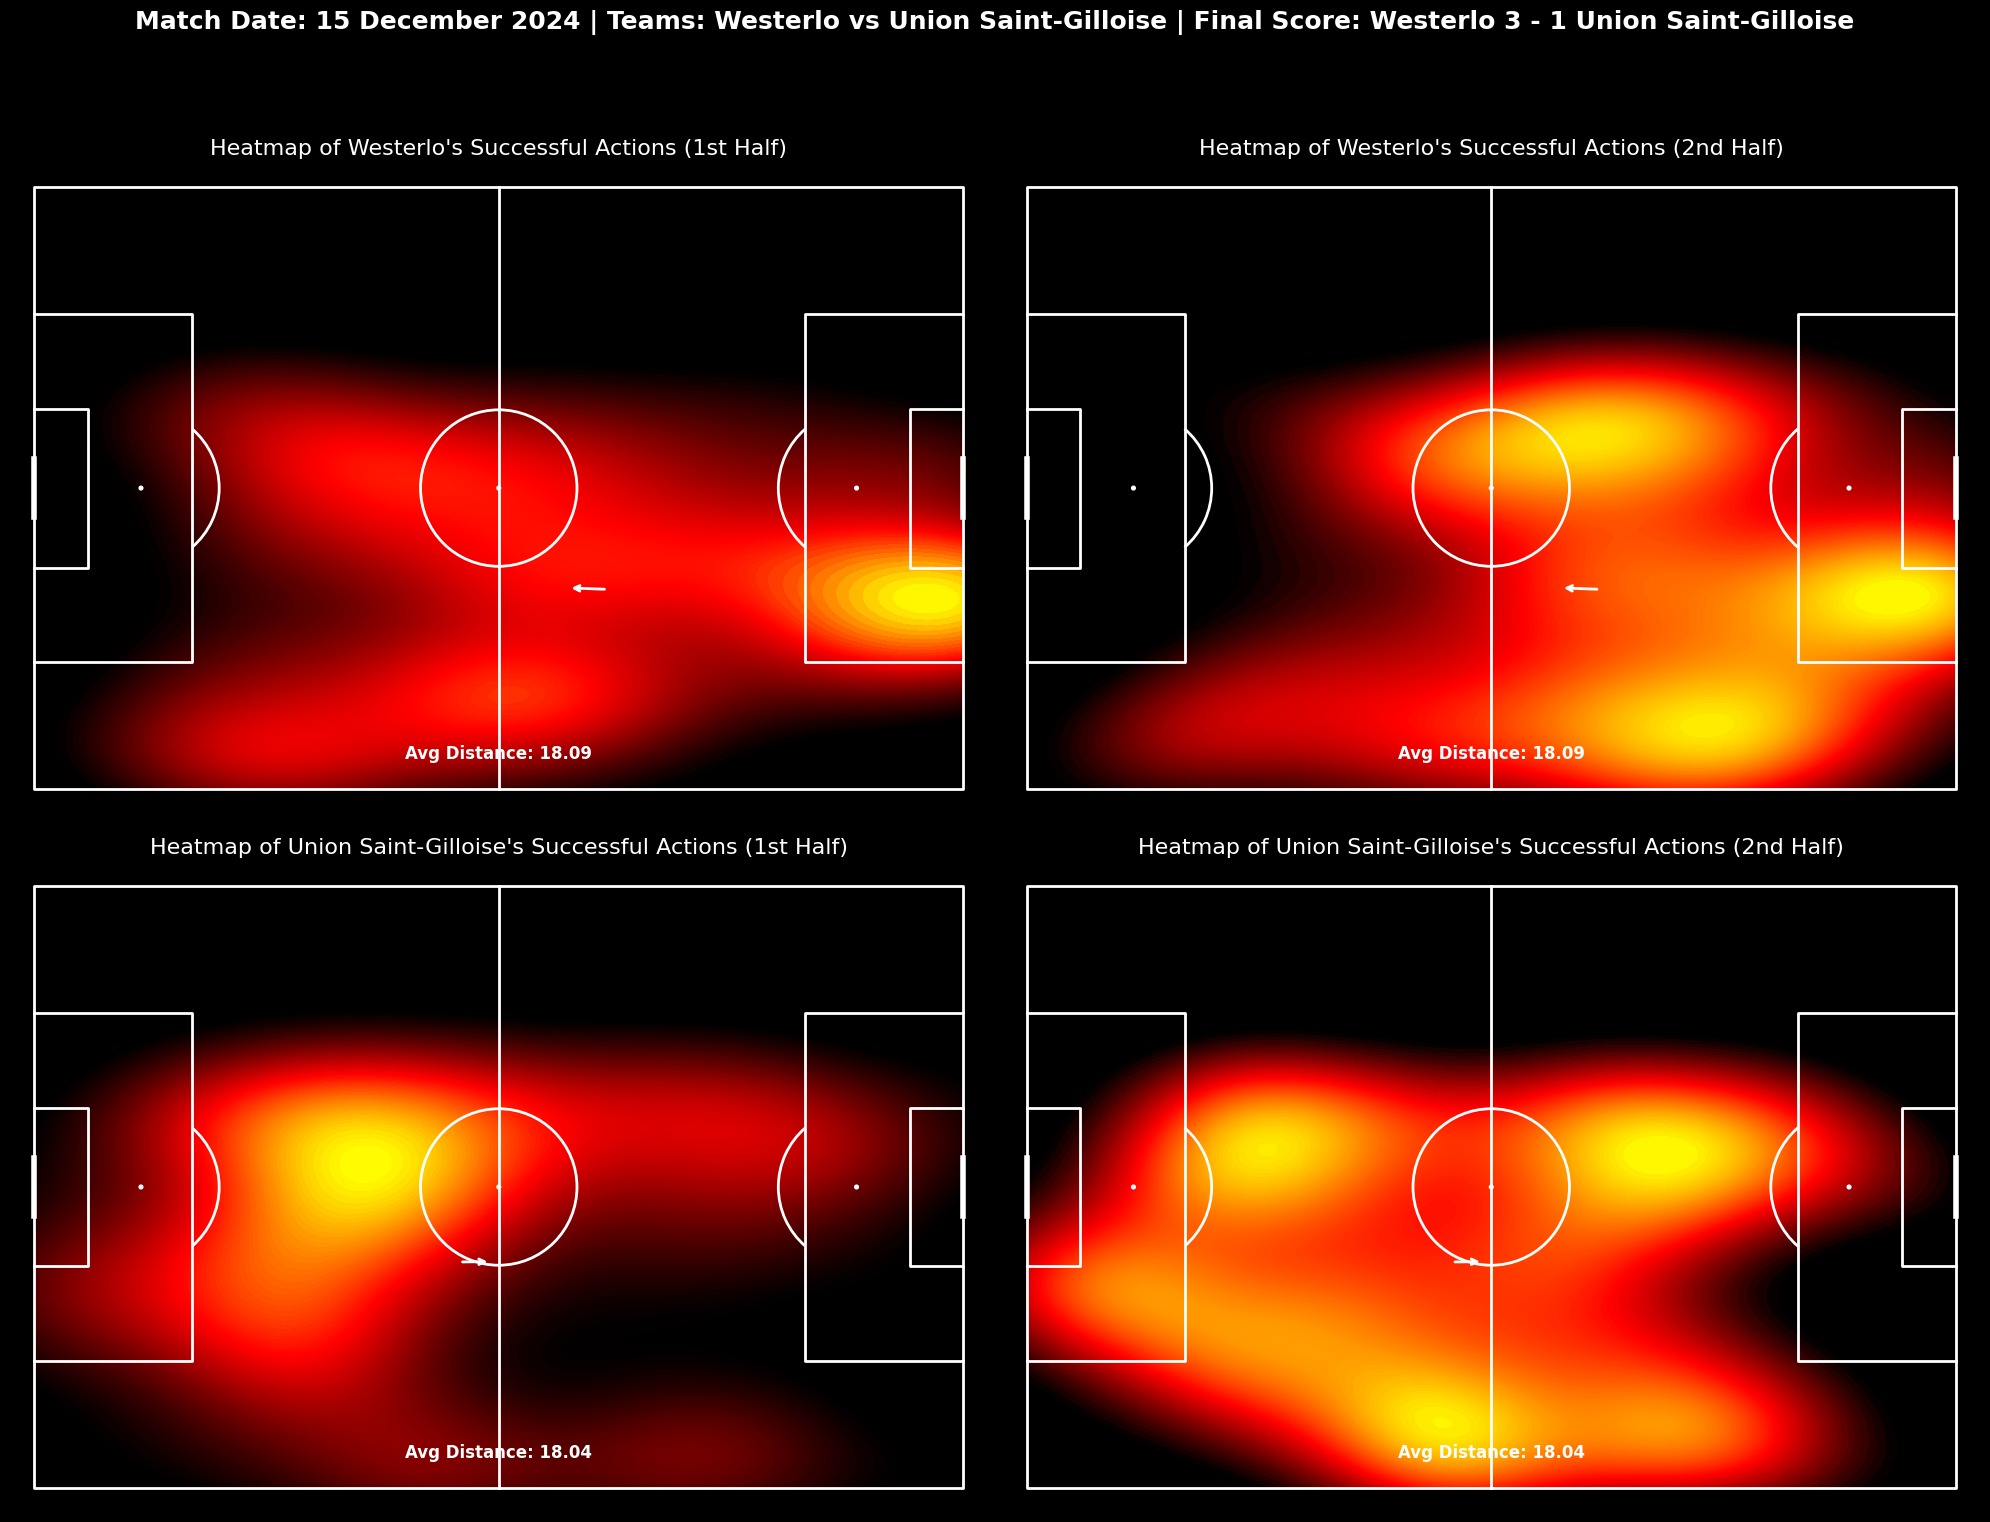

In [30]:
# Assuming you have already retrieved the necessary data for both teams
team_1 = "Westerlo"  # home_team
team_2 = "Union Saint-Gilloise"  # away_team

# Filter the actions for both teams (team 1 and team 2)
df_transition_action_success_team1 = df_transition_action[
    (df_transition_action['team_name'] == team_1) & 
    (df_transition_action['result'] == '1')
]

df_transition_action_success_team2 = df_transition_action[
    (df_transition_action['team_name'] == team_2) & 
    (df_transition_action['result'] == '1')
]

def compute_avg_movement(df):
    """
    Computes the average start and end positions of successful actions and the distance moved.
    
    Parameters:
    - df: The DataFrame containing the successful actions data.

    Returns:
    - avg_start_x: Average starting x coordinate
    - avg_start_y: Average starting y coordinate
    - avg_end_x: Average ending x coordinate
    - avg_end_y: Average ending y coordinate
    - dist_factor: Distance moved by the player (Euclidean distance)
    """
    if len(df) == 0:
        return None, None, None, None, None
    
    # Calculate average start and end positions
    avg_start_x = df['start_x'].mean()
    avg_start_y = df['start_y'].mean()
    avg_end_x = df['end_x'].mean()
    avg_end_y = df['end_y'].mean()

    # Calculate distance moved (Euclidean distance)
    dist_factor = ((df['end_x'] - df['start_x'])**2 + (df['end_y'] - df['start_y'])**2).mean()**0.5
    
    return avg_start_x, avg_start_y, avg_end_x, avg_end_y, dist_factor


# Calculate average movements for each team (team 1 and team 2)
avg_start_x_t1, avg_start_y_t1, avg_end_x_t1, avg_end_y_t1, dist_factor_t1 = compute_avg_movement(df_transition_action_success_team1)
avg_start_x_t2, avg_start_y_t2, avg_end_x_t2, avg_end_y_t2, dist_factor_t2 = compute_avg_movement(df_transition_action_success_team2)

# Get final score for both teams
home_score, away_score = get_final_score(game_id, conn)  # Replace with your game_id

def get_match_date(game_id, conn):
    query = """
    SELECT match_date 
    FROM public.matches 
    WHERE match_id = %(game_id)s;
    """
    result = pd.read_sql_query(query, conn, params={"game_id": game_id})
    
    if not result.empty:
        return result['match_date'].iloc[0]
    else:
        return None  # Or handle it according to your needs


# Fetch match date using game_id
match_date = get_match_date(game_id, conn)  # Retrieve match date from the database

# Ensure the match_date is a valid datetime object (if it's not already)
if isinstance(match_date, str):
    match_date = pd.to_datetime(match_date)  # Convert it if needed

# Format the match date
match_date_str = match_date.strftime("%d %B %Y")  # Format the date as "dd Month yyyy"

# Add match details to the supertitle
supertitle = f"Match Date: {match_date_str} | Teams: {team_1} vs {team_2} | Final Score: {team_1} {home_score} - {away_score} {team_2}"

# Create a figure with two side-by-side subplots for both teams
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.set_facecolor('black')

# Add the supertitle
fig.suptitle(supertitle, color='white', fontsize=18, weight='bold')

# Define a custom colormap
customcmap = matplotlib_colors.LinearSegmentedColormap.from_list('customcmap', ['black', 'red', 'yellow'])

# Heatmap for team 1 - Period 1
pitch_period1_t1 = mplsoccer.Pitch(pitch_type='opta', pitch_color='black', line_color='white', line_zorder=2)
pitch_period1_t1.draw(ax=axes[0, 0])
axes[0, 0].set_title(f"Heatmap of {team_1}'s Successful Actions (1st Half)", color='white', fontsize=16)

filtered_team1_period1 = df_transition_action_success_team1[df_transition_action_success_team1['period'] == 1]
pitch_period1_t1.kdeplot(
    filtered_team1_period1['start_x'], 
    filtered_team1_period1['start_y'], 
    ax=axes[0, 0], 
    cmap=customcmap, 
    fill=True, 
    n_levels=100, 
    zorder=1
)

if avg_start_x_t1 is not None:
    axes[0, 0].annotate(
        '', 
        xy=(avg_end_x_t1, avg_end_y_t1), 
        xytext=(avg_start_x_t1, avg_start_y_t1),
        arrowprops=dict(arrowstyle='->', lw=2, color='white')
    )
    axes[0, 0].text(
        50, 5, f"Avg Distance: {dist_factor_t1:.2f}", 
        fontsize=12, color='white', weight='bold', ha='center'
    )

# Heatmap for team 1 - Period 2
pitch_period2_t1 = mplsoccer.Pitch(pitch_type='opta', pitch_color='black', line_color='white', line_zorder=2)
pitch_period2_t1.draw(ax=axes[0, 1])
axes[0, 1].set_title(f"Heatmap of {team_1}'s Successful Actions (2nd Half)", color='white', fontsize=16)

filtered_team1_period2 = df_transition_action_success_team1[df_transition_action_success_team1['period'] == 2]
pitch_period2_t1.kdeplot(
    filtered_team1_period2['start_x'], 
    filtered_team1_period2['start_y'], 
    ax=axes[0, 1], 
    cmap=customcmap, 
    fill=True, 
    n_levels=100, 
    zorder=1
)

if avg_start_x_t1 is not None:
    axes[0, 1].annotate(
        '', 
        xy=(avg_end_x_t1, avg_end_y_t1), 
        xytext=(avg_start_x_t1, avg_start_y_t1),
        arrowprops=dict(arrowstyle='->', lw=2, color='white')
    )
    axes[0, 1].text(
        50, 5, f"Avg Distance: {dist_factor_t1:.2f}", 
        fontsize=12, color='white', weight='bold', ha='center'
    )

# Heatmap for team 2 - Period 1
pitch_period1_t2 = mplsoccer.Pitch(pitch_type='opta', pitch_color='black', line_color='white', line_zorder=2)
pitch_period1_t2.draw(ax=axes[1, 0])
axes[1, 0].set_title(f"Heatmap of {team_2}'s Successful Actions (1st Half)", color='white', fontsize=16)

filtered_team2_period1 = df_transition_action_success_team2[df_transition_action_success_team2['period'] == 1]
pitch_period1_t2.kdeplot(
    filtered_team2_period1['start_x'], 
    filtered_team2_period1['start_y'], 
    ax=axes[1, 0], 
    cmap=customcmap, 
    fill=True, 
    n_levels=100, 
    zorder=1
)

if avg_start_x_t2 is not None:
    axes[1, 0].annotate(
        '', 
        xy=(avg_end_x_t2, avg_end_y_t2), 
        xytext=(avg_start_x_t2, avg_start_y_t2),
        arrowprops=dict(arrowstyle='->', lw=2, color='white')
    )
    axes[1, 0].text(
        50, 5, f"Avg Distance: {dist_factor_t2:.2f}", 
        fontsize=12, color='white', weight='bold', ha='center'
    )

# Heatmap for team 2 - Period 2
pitch_period2_t2 = mplsoccer.Pitch(pitch_type='opta', pitch_color='black', line_color='white', line_zorder=2)
pitch_period2_t2.draw(ax=axes[1, 1])
axes[1, 1].set_title(f"Heatmap of {team_2}'s Successful Actions (2nd Half)", color='white', fontsize=16)

filtered_team2_period2 = df_transition_action_success_team2[df_transition_action_success_team2['period'] == 2]
pitch_period2_t2.kdeplot(
    filtered_team2_period2['start_x'], 
    filtered_team2_period2['start_y'], 
    ax=axes[1, 1], 
    cmap=customcmap, 
    fill=True, 
    n_levels=100, 
    zorder=1
)

if avg_start_x_t2 is not None:
    axes[1, 1].annotate(
        '', 
        xy=(avg_end_x_t2, avg_end_y_t2), 
        xytext=(avg_start_x_t2, avg_start_y_t2),
        arrowprops=dict(arrowstyle='->', lw=2, color='white')
    )
    axes[1, 1].text(
        50, 5, f"Avg Distance: {dist_factor_t2:.2f}", 
        fontsize=12, color='white', weight='bold', ha='center'
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for supertitle
plt.show()



In [7]:
%pip install matplotsoccer -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Not enough preceding actions to visualize for goal at 288.0s.
Not enough preceding actions to visualize for goal at 321.0s.


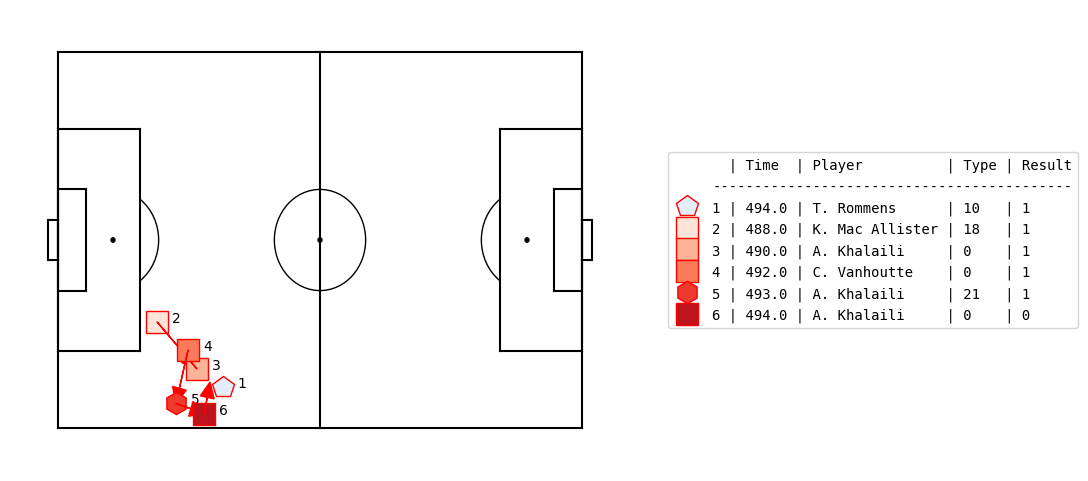

Visualization for goal at 494.0s:


None

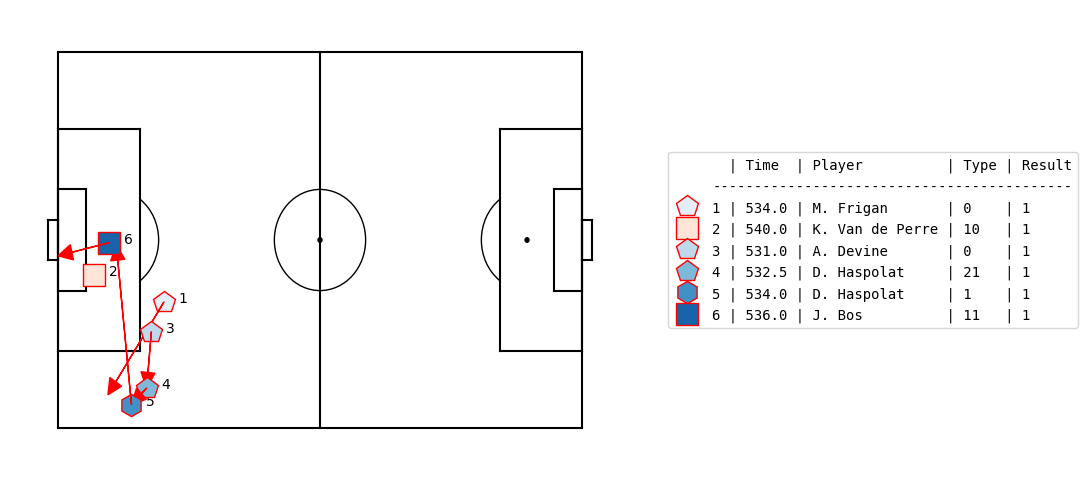

Visualization for goal at 540.0s:


None

Not enough preceding actions to visualize for goal at 833.0s.


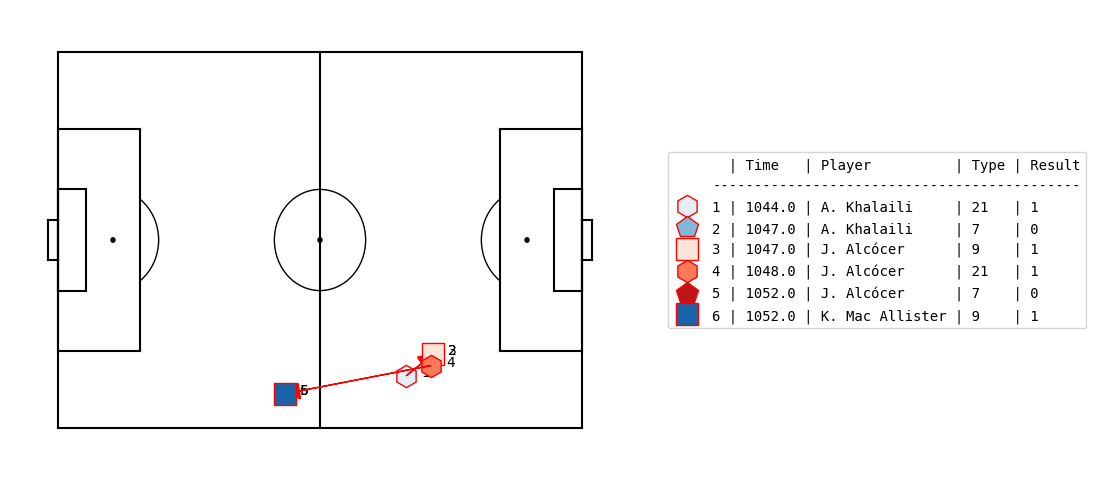

Visualization for goal at 1053.0s:


None

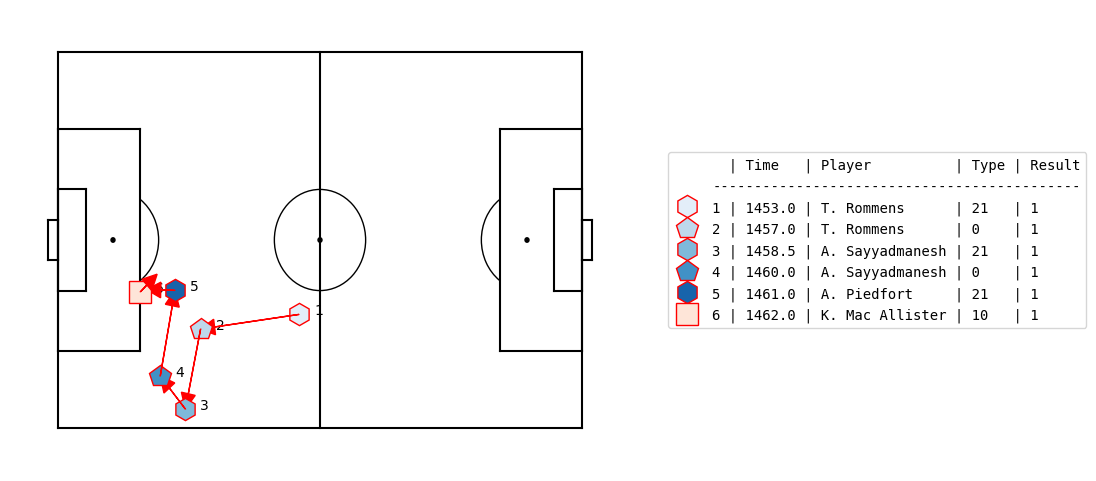

Visualization for goal at 1462.0s:


None

Not enough preceding actions to visualize for goal at 1774.0s.


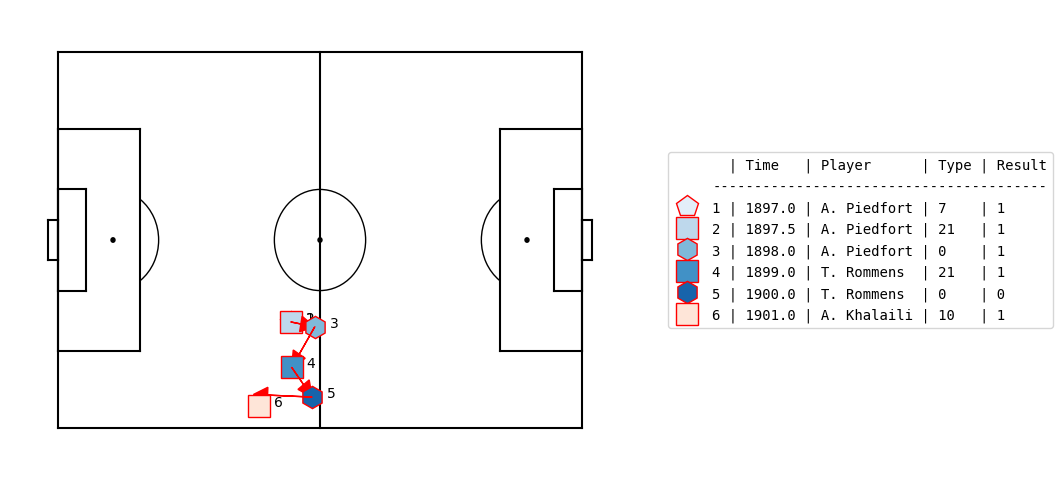

Visualization for goal at 1901.0s:


None

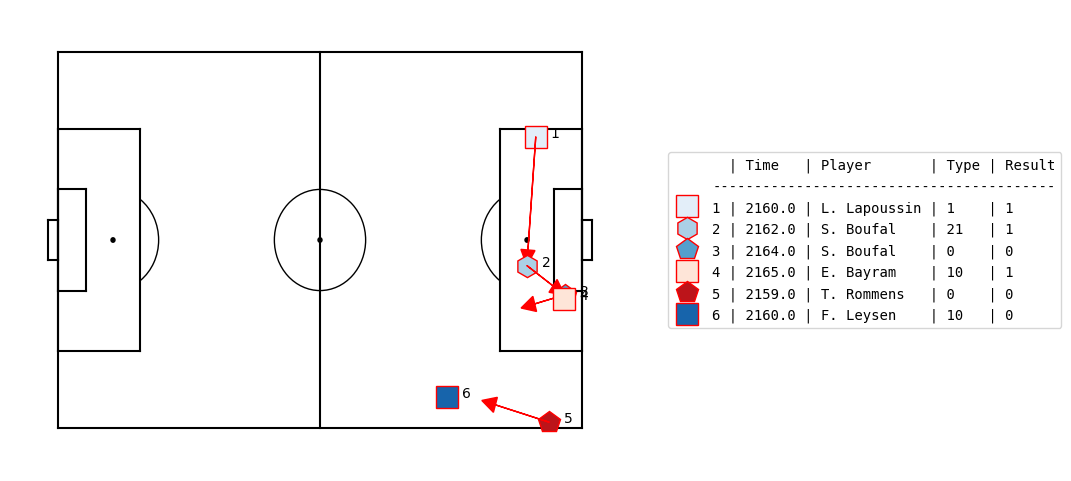

Visualization for goal at 2165.0s:


None

Not enough preceding actions to visualize for goal at 2582.0s.


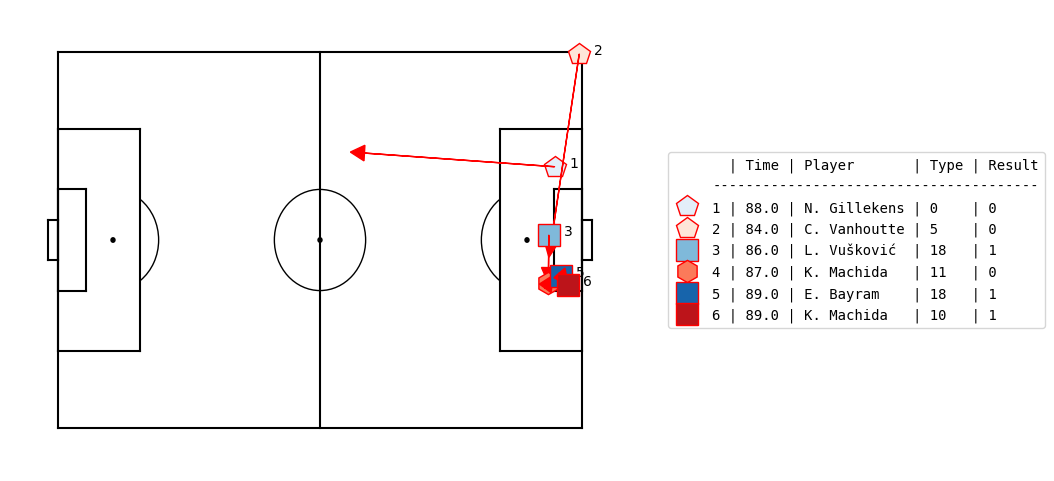

Visualization for goal at 89.0s:


None

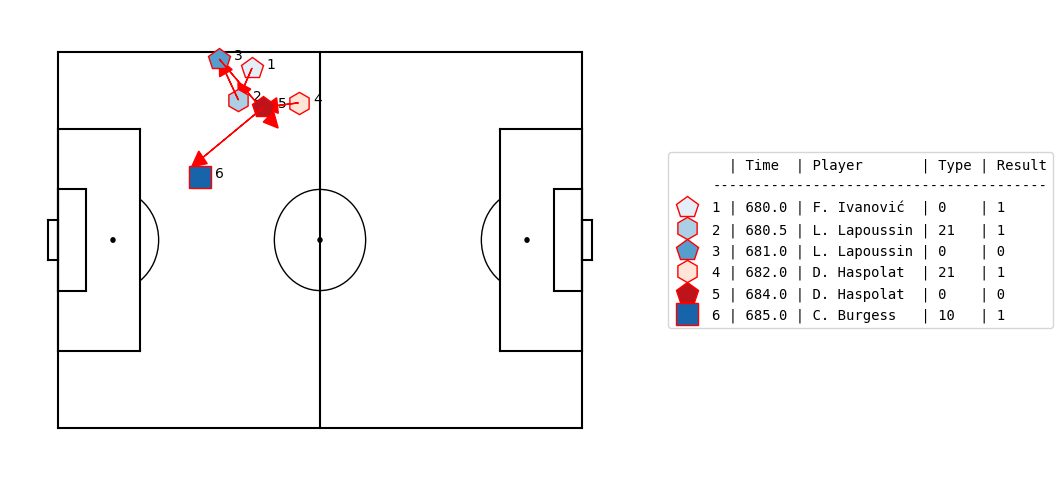

Visualization for goal at 685.0s:


None

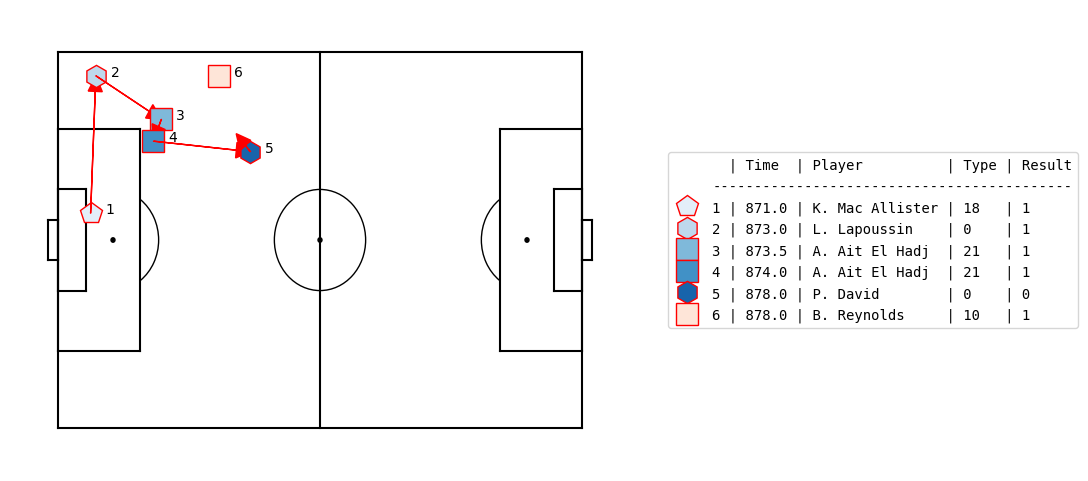

Visualization for goal at 878.0s:


None

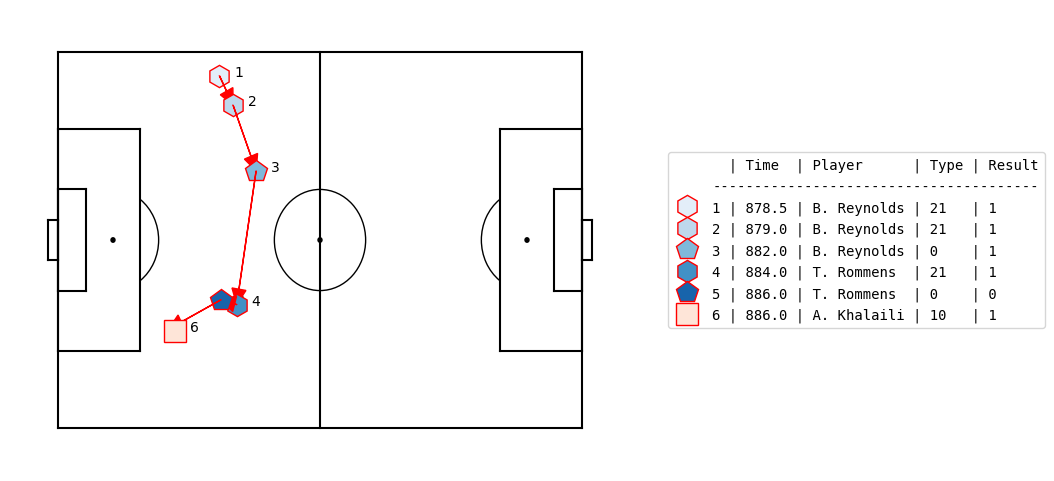

Visualization for goal at 886.0s:


None

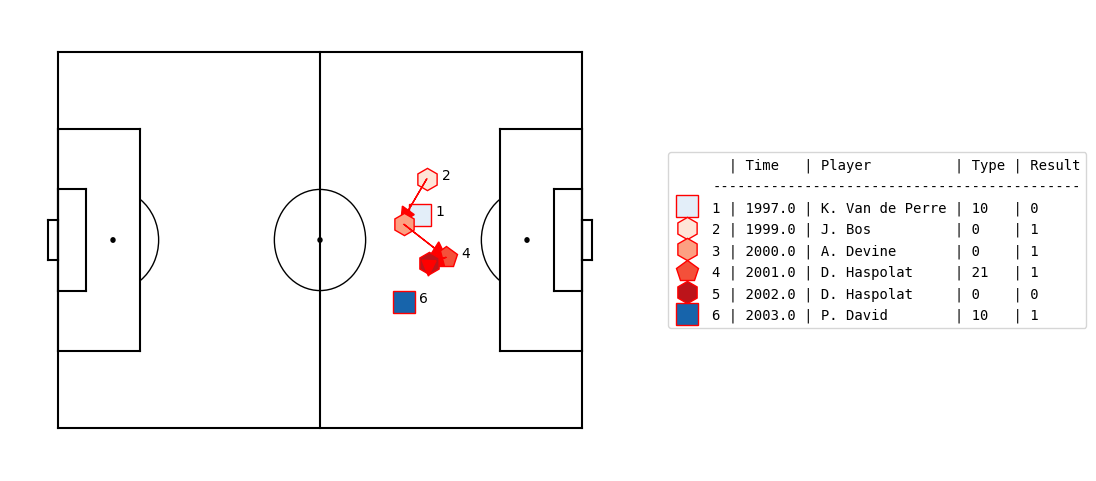

Visualization for goal at 2003.0s:


None

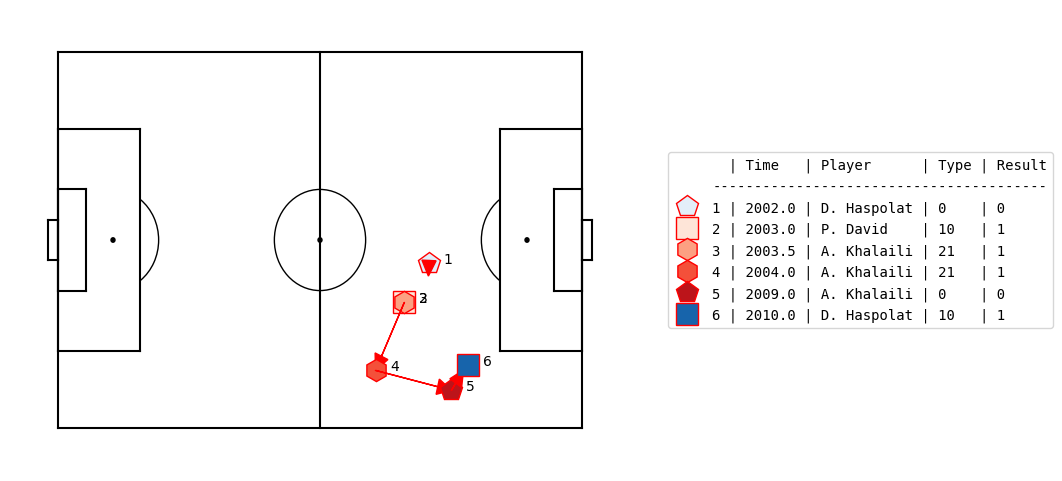

Visualization for goal at 2010.0s:


None

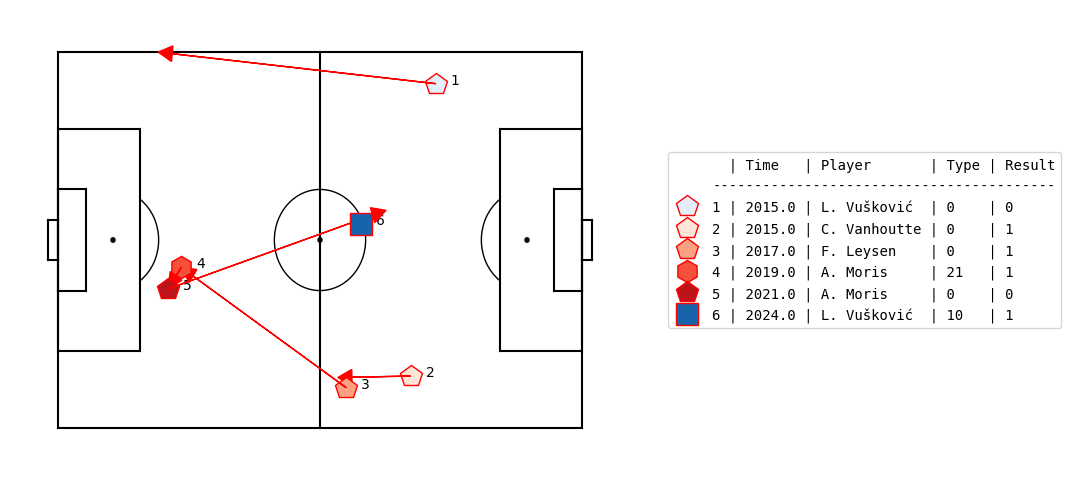

Visualization for goal at 2024.0s:


None

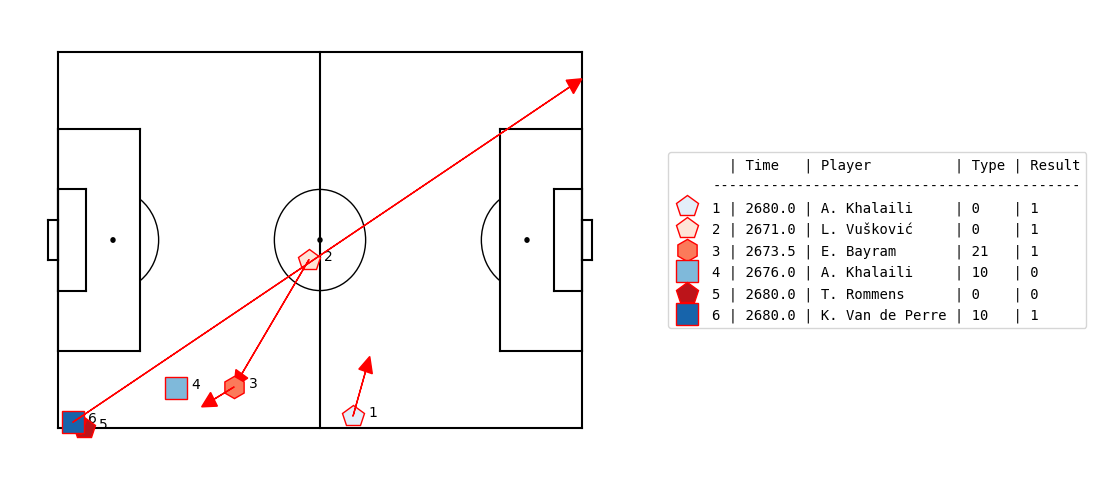

Visualization for goal at 2680.0s:


None

Not enough preceding actions to visualize for goal at 2789.0s.


In [32]:
import matplotsoccer

# Filter actions that resulted in a goal
goal_actions = df_transition_action[df_transition_action['is_goal'] == 1]

if len(goal_actions) == 0:
    print("No goals found in the dataset.")
else:
    for i, goal in goal_actions.iterrows():
        # Get the 6 actions preceding each goal
        goal_time = goal['second']
        preceding_actions = df_transition_action[
            (df_transition_action['second'] <= goal_time) & 
            (df_transition_action['second'] > goal_time - 10)
        ].iloc[-6:]  # Select the last 6 actions within the 10 seconds prior to the goal
        
        if len(preceding_actions) < 6:
            print(f"Not enough preceding actions to visualize for goal at {goal_time}s.")
            continue
        
        # Generate the visualization for these 6 actions
        ax = matplotsoccer.actions(
            location=preceding_actions[["start_x", "start_y", "end_x", "end_y"]],
            action_type=preceding_actions["action_type"],
            team=preceding_actions["team_name"],
            result=preceding_actions["result"] == "success",
            label=preceding_actions[["second", "player_name", "action_type", "result"]],
            labeltitle=["Time", "Player", "Type", "Result"],
            zoom=False,
            figsize=8,
        )
        
        print(f"Visualization for goal at {goal_time}s:")
        display(ax)